In [1]:
GPU = 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU)

import os
from models import TransformerModel
from tasks import get_task_sampler
from samplers import get_data_sampler
import torch
import numpy as np

import time



In [12]:
def eval_batch(model, 
               percent_above_thresh, 
               use_clamped_y=True, 
               last_pt_above_thresh=True, 
               last_pt_use_clamped_y=True, 
               window_len=41, 
               thresh=0.5,
               b_size=1, 
               smoothing=0
    ):
    
    get_clamped_task = lambda : get_task_sampler( "clamped_chebyshev", 1, b_size)()
    get_orig_task = lambda : get_task_sampler( "chebyshev_kernel_linear_regression", 1, b_size)()
    get_ds = lambda : get_data_sampler('gaussian', 1)

    if torch.cuda.is_available() and model.name.split("_")[0] in ["gpt2", "lstm"]:
        device = "cuda"
    else:
        device = "cpu"

    # sample 100 x points
    # keep sampling a batch of 100 x points until we have % 0.5 ys>=percent_clamped
    # then, depending on the context length, select percent_clamped *context_window (x,y) pairs, and randomly select the rest from the remaining points

    num_clamped_needed = int(percent_above_thresh*window_len)
    num_other_needed = int(window_len - num_clamped_needed)

    done = False
    while not done: 
        task = get_clamped_task()
        data_sampler = get_ds()
        
        xs = data_sampler.sample_xs(n_points=100, b_size=b_size)
        ys = task.evaluate(xs, noise=False, separate_noise=False)
        if not use_clamped_y:
            orig_task = get_orig_task()
            ys_orig = orig_task.evaluate(xs, noise=False, separate_noise=False)
        
        # print(f'clamped {torch.where(ys[0]==0.5)[0].size(0)}, other {torch.where(ys[0]!=0.5)[0].size(0)}')
        done = torch.where(ys[0]==thresh)[0].size(0) >= num_clamped_needed and torch.where(ys[0]!=thresh)[0].size(0) >= num_other_needed # use 1 bc dont want batch dim
        
    # ys still equals the ys with clamping -- need this to randomly sample the right number of clamped indices
    # select percent_clamped_correct * window_len points
    clamped_indices = torch.where(ys[0]==thresh)[0]
    indices = torch.multinomial(torch.ones(len(clamped_indices)), num_clamped_needed, replacement=False)  # select indices
    clamped_indices = clamped_indices[indices]

    # select the rest randomly
    remaining_indices = torch.where(ys[0]!=thresh)[0]
    indices = torch.multinomial(torch.ones(len(remaining_indices)), num_other_needed, replacement=False)  # select indices
    remaining_indices = remaining_indices[indices]

    # now make ys = the unclamped y values if needed
    if not use_clamped_y:
        ys = ys_orig

    # we use the indices calculated from the clamping to index into the unclamped ys
    clamped_xs = xs[:, clamped_indices]
    clamped_ys = ys[:, clamped_indices]
    
    remaining_xs = xs[:, remaining_indices]
    remaining_ys = ys[:, remaining_indices]

    # save last point
    if last_pt_above_thresh:
        last_x= clamped_xs[:, -1]
        if last_pt_use_clamped_y:
            last_y = torch.tensor([thresh])
        else:
            last_y = clamped_ys[:, -1]
        clamped_xs = clamped_xs[:, :-1]
    else:
        last_x, last_y = remaining_xs[:, -1], remaining_ys[:, -1]
        remaining_xs = remaining_xs[:, :-1]

    # combine clamped & remaining
    xs = torch.cat([clamped_xs, remaining_xs], dim=1)
    ys = torch.cat([clamped_ys, remaining_ys], dim=1)

    # shuffle order of xs and ys(but together)
    perm = torch.randperm(xs.shape[1])
    xs = xs[:, perm]
    ys = ys[:, perm]

    # add back last point
    xs = torch.cat((xs, last_x[:, :, None]), dim=1)
    ys = torch.cat((ys, last_y[:, None]), dim=1)

    pred = model(xs.to(device), ys.to(device)).detach()

    perturbations = np.arange(-1 * smoothing, smoothing + 0.002, 0.002)
    predictions = torch.zeros(len(perturbations), xs.shape[0], xs.shape[1])
    predictions = pred.cpu() # (64, 41)

    predictions = predictions[:, window_len-1]

    return ys[:,  window_len-1], predictions

def build_model():
    model = TransformerModel(
        n_dims=1,
        n_positions=41,
        n_embd=512,
        n_layer=24,
        n_head=16,
    )
    return model


In [3]:

model = build_model()
torch.cuda.set_device(0)
model.cuda()

ckpt_path = '/home/riadoshi/alignment/Alignment/models/finetune/go_time/'
# ckpt_path = '/home/riadoshi/alignment/prev/ckpts/ckpt/'
base_model = os.path.join(ckpt_path, "state.pt")
state = torch.load(base_model, map_location='cuda:0')
model.load_state_dict(state["model_state_dict"])
b_size = 1


In [17]:
last_pt_clamped=True # we want this to predict the last point clamped
percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_per_pc = 500
mse = []

for pc in percent_clamped:
    pc_mse = 0
    for _ in range(num_per_pc):
        y, pred = eval_batch(model, percent_above_thresh=pc, use_clamped_y=True, last_pt_above_thresh=True, last_pt_use_clamped_y=True)
        pc_mse+= np.sqrt((pred-y)**2)
        
    mse.append(pc_mse/num_per_pc)

/home/riadoshi/miniconda3/envs/in-context-learning/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/riadoshi/miniconda3/envs/in-context-learning/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


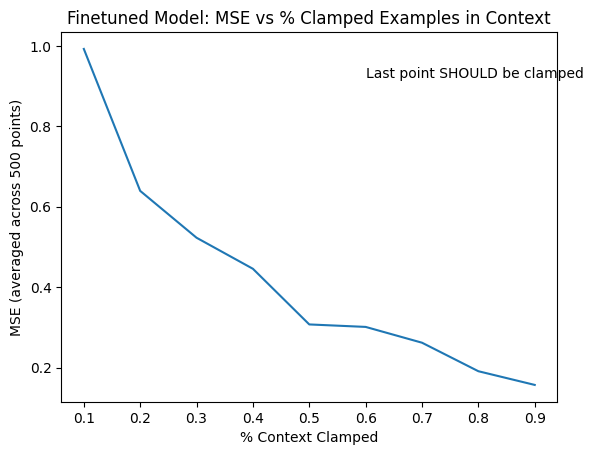

In [18]:
import matplotlib.pyplot as plt
plt.xlabel('% Context Clamped')
plt.ylabel('MSE (averaged across 500 points)')
plt.title('Finetuned Model: MSE vs % Clamped Examples in Context')
# add a note on the graph
plt.text(0.6, 0.92, 'Last point SHOULD be clamped')
plt.plot(percent_clamped, mse)


In [ ]:
## FOR ORIGINAL MODEL

In [21]:
last_pt_clamped=True
percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_per_pc = 500
mse = []

for pc in percent_clamped:
    pc_mse = 0
    for _ in range(num_per_pc):
        y, pred = eval_batch(model, percent_clamped_correct=pc, last_pt_clamped=last_pt_clamped)
        pc_mse+= np.sqrt((pred-y)**2)
        
    mse.append(pc_mse/num_per_pc)
    

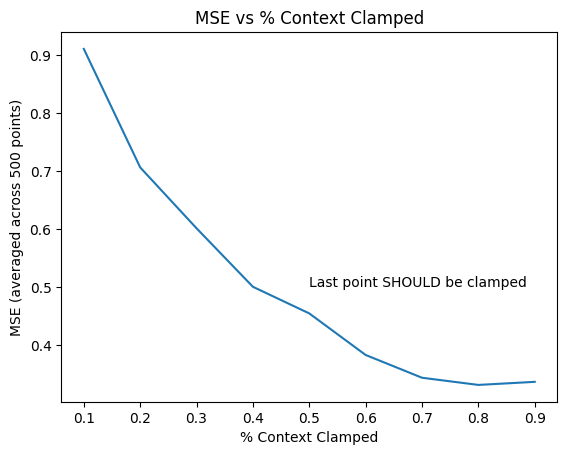

In [24]:
import matplotlib.pyplot as plt
# give plot x axis title
plt.xlabel('% Context Clamped')
plt.ylabel('MSE (averaged across 500 points)')
plt.title('MSE vs % Context Clamped')
# add a note on the graph
plt.text(0.5, 0.5, 'Last point SHOULD be clamped')
plt.plot(percent_clamped, mse)

In [20]:
# how do original, non-clamped points do when the context has clamped points? 
last_pt_clamped=False
percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_per_pc = 500
fmse = []

for pc in percent_clamped:
    pc_mse = 0
    for _ in range(num_per_pc):
        y, pred = eval_batch(model, percent_clamped_correct=pc, last_pt_clamped=last_pt_clamped)
        pc_mse+= np.sqrt((pred-y)**2)
        
    fmse.append(pc_mse/num_per_pc)
    

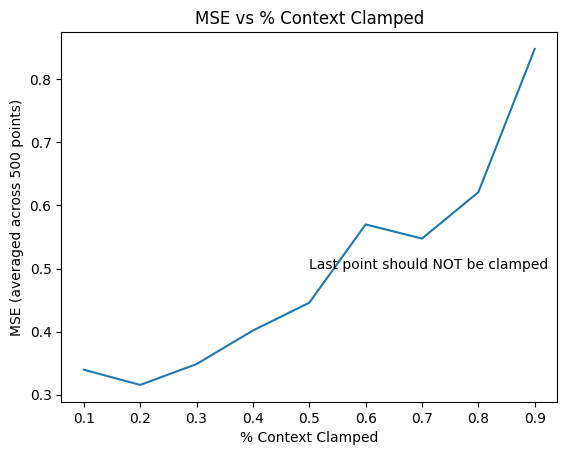

In [27]:
import matplotlib.pyplot as plt
# give plot x axis title
plt.xlabel('% Context Clamped')
plt.ylabel('MSE (averaged across 500 points)')
plt.title('MSE vs % Context Clamped')
# add a note on the graph
plt.text(0.5, 0.5, 'Last point should NOT be clamped')
plt.plot(percent_clamped, fmse)

In [19]:
# sanity check original behavior: 
# how do original, non-clamped points do when the context has clamped points? 
# last_pt_clamped=False
# num_per_pc = 50
# sanity_mse = 0

# for _ in range(num_per_pc):
#     pc = 0.05 + np.random.rand() * 0.9
#     y, pred = eval_batch(model, percent_above_thresh=pc, use_clamped_y=False, last_pt_clamped=last_pt_clamped)
#     print((y, pred, np.sqrt((pred-y)**2)))
#     sanity_mse+= np.sqrt((pred-y)**2)
    
# sanity_mse /= num_per_pc
    

In [40]:
# print(sanity_mse)

tensor([0.6601])
